<div style="text-align: center;">
    <h1 style="
        background: linear-gradient(135deg, #020b22ff, #33485eff);
        color: white; 
        padding: 15px 30px; 
        border-radius: 500px; 
        font-family: 'Segoe UI', Arial, sans-serif; 
        box-shadow: 0 4px 15px rgba(0,0,0,0.3);
        display: inline-block;
    ">
       Facial Recognition System using Convolutional Neural Networks
    </h1>
</div>


<h4 style="color:#96c9ffff">
1. Importing essential and advanced libraries for image and video processing, CNN-based face detection, data handling with NumPy/Pandas, and visualization with Matplotlib, PIL, and OpenCV, supported by MTCNN and deep learning (TensorFlow & Keras).
</h4>


In [501]:
import os, random, math, time
from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
plt.style.use("ggplot")
import cv2
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


<h4 style="color:#96c9ffff">
2. Defining dataset paths, creating the aligned dataset directory if it does not exist, and setting the target image size (128×128) for preprocessing in the Facial Recognition System.
</h4>


In [502]:
DATA_ROOT = Path(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\lfw-deepfunneled")
ALIGNED_ROOT = Path(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\lfw-aligned-128")
ALIGNED_ROOT.mkdir(parents=True, exist_ok=True)
TARGET_SIZE = (128, 128)

<h4 style="color:#96c9ffff">
3. Randomly selecting a person folder and an image, loading it as raw data, decoding with OpenCV, and converting the image from BGR to RGB format for further processing.
</h4>


In [ ]:
person_dir = random.choice([p for p in DATA_ROOT.iterdir() if p.is_dir()])
img_path = random.choice([p for p in person_dir.iterdir() if p.suffix.lower() in [".jpg", ".jpeg", ".png"]])
data = np.fromfile(str(img_path), dtype=np.uint8)
img_bgr = cv2.imdecode(data, cv2.IMREAD_COLOR)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

<h4 style="color:#96c9ffff">
4. Defining the <code>align_and_crop</code> function to detect face bounding boxes and keypoints, apply margin and rotation for eye alignment, crop the face region, and resize it to the target size (128×128) for consistent preprocessing.
</h4>


In [504]:
def align_and_crop(rgb, det, target=(128,128), margin=0.2):
    x, y, w, h = det['box']
    x, y = max(0, x), max(0, y)
    mx, my = int(margin*w), int(margin*h)

    x1, y1 = max(0, x - mx), max(0, y - my)
    x2, y2 = min(rgb.shape[1], x + w + mx), min(rgb.shape[0], y + h + my)

    kps = det.get('keypoints', {})
    if 'left_eye' in kps and 'right_eye' in kps:
        (lx, ly), (rx, ry) = kps['left_eye'], kps['right_eye']
        dy, dx = (ry - ly), (rx - lx)
        angle = np.degrees(np.arctan2(dy, dx))
        M = cv2.getRotationMatrix2D(((x1+x2)//2, (y1+y2)//2), angle, 1.0)
        rot = cv2.warpAffine(rgb, M, (rgb.shape[1], rgb.shape[0]), flags=cv2.INTER_LINEAR)
        crop = rot[y1:y2, x1:x2]
    else:
        crop = rgb[y1:y2, x1:x2]

    if crop.size == 0:
        return None
    return cv2.resize(crop, target, interpolation=cv2.INTER_AREA)

<h4 style="color:#96c9ffff">
5. Initializing the MTCNN face detector and defining the <code>process_image</code> function to load an image, detect the largest face, align and crop it with a margin, then save the preprocessed face image to the target path.
</h4>

In [ ]:
detector = MTCNN()
dets = detector.detect_faces(img_rgb)
MARGIN = 0.20 
def process_image(path_in: Path, path_out: Path) -> bool:
    bgr = cv2.imdecode(np.fromfile(str(path_in), np.uint8), cv2.IMREAD_COLOR)
    if bgr is None:
        return False
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    dets = detector.detect_faces(rgb)
    if len(dets) == 0:
        return False
    det = max(dets, key=lambda d: d['box'][2]*d['box'][3]) 
    aligned = align_and_crop(rgb, det, target=TARGET_SIZE, margin=MARGIN)
    if aligned is None:
        return False
    path_out.parent.mkdir(parents=True, exist_ok=True)
    cv2.imencode(".jpg", cv2.cvtColor(aligned, cv2.COLOR_RGB2BGR))[1].tofile(str(path_out))
    return True


Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\Rammah\anaconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\Rammah\anaconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.
Exception ignored in: <_io.BufferedReader>
Traceback (most recent call last):
  File "c:\Users\Rammah\anaconda3\Lib\site-packages\lz4\frame\__init__.py", line 753, in flush
    self._fp.flush()
ValueError: I/O operation on closed file.


<h4 style="color:#96c9ffff">
6. Visualizing the detected faces by drawing bounding boxes on the original image using OpenCV and displaying the result with Matplotlib.
</h4>

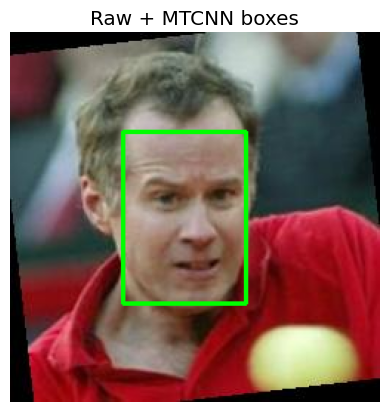

In [506]:
vis = img_rgb.copy()
for d in dets:
    x,y,w,h = d['box']
    x,y = max(0,x), max(0,y)
    cv2.rectangle(vis, (x,y), (x+w, y+h), (0,255,0), 2)
plt.imshow(vis); plt.axis("off"); plt.title("Raw + MTCNN boxes"); plt.show()


<h4 style="color:#96c9ffff">
7. Displaying the raw image alongside each detected and aligned face, using Matplotlib subplots for side-by-side visualization.
</h4>

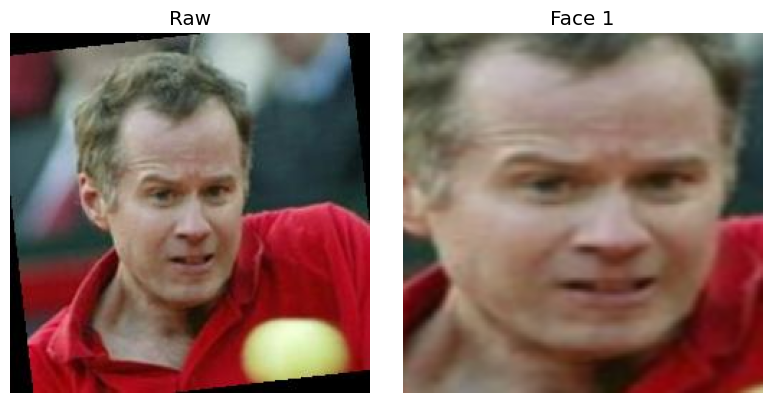

In [507]:
fig, axes = plt.subplots(1, len(dets)+1, figsize=(4*(len(dets)+1), 4))
axes[0].imshow(img_rgb); axes[0].axis("off"); axes[0].set_title("Raw")

for i, det in enumerate(dets, start=1):
    aligned = align_and_crop(img_rgb, det, target=TARGET_SIZE, margin=MARGIN)
    if aligned is not None:
        axes[i].imshow(aligned); axes[i].axis("off"); axes[i].set_title(f"Face {i}")

plt.tight_layout(); plt.show()


<h4 style="color:#96c9ffff">
8. Iterating through all person folders and images, processing and aligning valid face images, saving them into the aligned dataset directory, and reporting success and failure counts.
</h4>

In [508]:
ok, fail = 0, 0
valid_exts = [".jpg", ".jpeg", ".png"]
for person in [p for p in DATA_ROOT.iterdir() if p.is_dir()]:
    for img in person.iterdir():
        if img.suffix.lower() not in valid_exts: 
            continue
        dst = ALIGNED_ROOT / person.name / img.name
        if dst.exists(): 
            continue
        if process_image(img, dst):
            ok += 1
        else:
            fail += 1
print(f"Saved aligned faces: {ok} | Failed: {fail}")

Saved aligned faces: 0 | Failed: 1


<h4 style="color:#96c9ffff">
9. Scanning all dataset images to extract width, height, and area statistics, then reporting total processed images along with min, max, and median values for each dimension.
</h4>

In [509]:
widths, heights, areas = [], [], []
for img_path in DATA_ROOT.rglob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        try:
            img = cv2.imdecode(np.fromfile(str(img_path), np.uint8), cv2.IMREAD_COLOR)
            if img is None: 
                continue
            h, w = img.shape[:2]
            widths.append(w); heights.append(h); areas.append(w*h)
        except Exception as e:
            print("Could not open:", img_path, "| Error:", e)

print(f"Total images processed: {len(areas)}")
print("Width:  min/max/median:", min(widths), max(widths), float(np.median(widths)))
print("Height: min/max/median:", min(heights), max(heights), float(np.median(heights)))
print("Area:   min/max/median:", min(areas), max(areas), float(np.median(areas)))


Total images processed: 13233
Width:  min/max/median: 250 250 250.0
Height: min/max/median: 250 250 250.0
Area:   min/max/median: 62500 62500 62500.0


<h4 style="color:#96c9ffff">
10. Analyzing the aligned dataset by computing width, height, and area statistics for all images, printing summary values, and visualizing distributions with histograms.
</h4>

Total aligned images: 13232
Width (min/max/median): 128 128 128.0
Height (min/max/median): 128 128 128.0


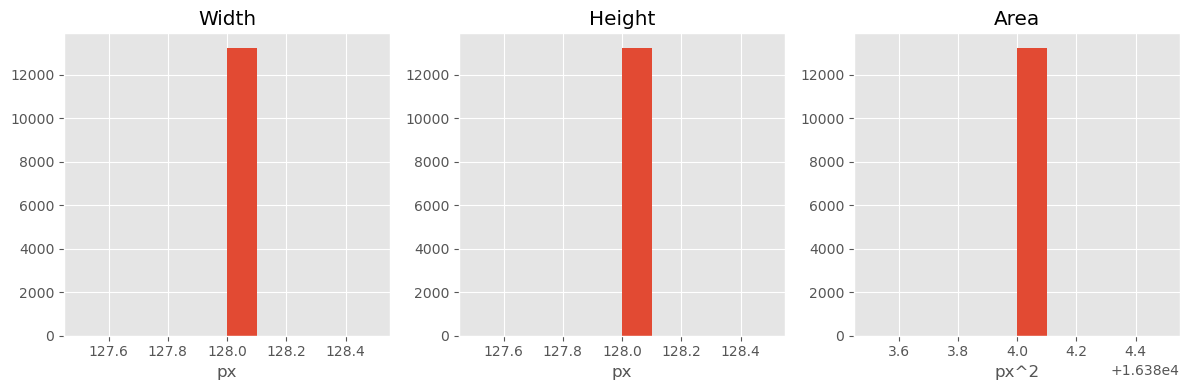

In [510]:
w2, h2, a2 = [], [], []
for img_path in ALIGNED_ROOT.rglob("*"):
    if img_path.suffix.lower() in [".jpg", ".jpeg", ".png"]:
        try:
            im = cv2.imdecode(np.fromfile(str(img_path), np.uint8), cv2.IMREAD_COLOR)
            if im is None: 
                continue
            h, w = im.shape[:2]
            w2.append(w); h2.append(h); a2.append(w*h)
        except Exception as e:
            print("Could not open:", img_path, "|", e)

print("Total aligned images:", len(a2))
print("Width (min/max/median):", min(w2), max(w2), float(np.median(w2)))
print("Height (min/max/median):", min(h2), max(h2), float(np.median(h2)))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.hist(w2, bins=10); plt.title("Width");  plt.xlabel("px")
plt.subplot(1,3,2); plt.hist(h2, bins=10); plt.title("Height"); plt.xlabel("px")
plt.subplot(1,3,3); plt.hist(a2, bins=10); plt.title("Area");   plt.xlabel("px^2")
plt.tight_layout(); plt.show()

<h4 style="color:#96c9ffff">
11. Loading the face verification pairs dataset from CSV, counting the total number of pairs, and reporting the number of unique individuals.
</h4>


In [ ]:
matchpairsDevTest_df = pd.read_csv(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\matchpairsDevTest.csv")
print("Total pairs:", len(matchpairsDevTest_df))
print("Unique people:", matchpairsDevTest_df["name"].nunique())

Total pairs: 500
Unique people: 353


<h4 style="color:#96c9ffff">
12. Counting face occurrences in the verification pairs dataset, extracting the top 10 most frequent individuals, and visualizing their frequencies with a bar chart.
</h4>

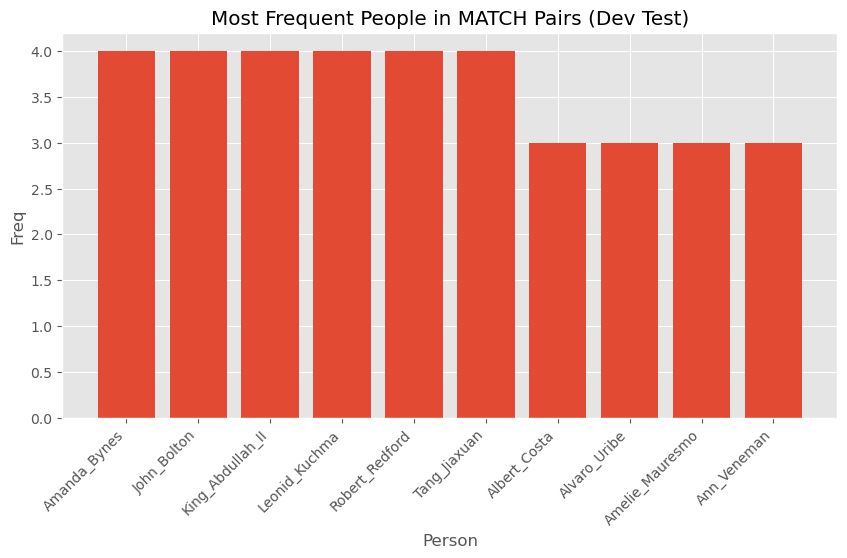

In [512]:
counts_match_test = Counter(matchpairsDevTest_df["name"])
top10 = dict(sorted(counts_match_test.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10,5))
plt.bar(top10.keys(), top10.values()); plt.xticks(rotation=45, ha="right")
plt.title("Most Frequent People in MATCH Pairs (Dev Test)"); plt.xlabel("Person"); plt.ylabel("Freq")
plt.show()

<h4 style="color:#96c9ffff">
13. Loading mismatch pairs (train and test), aggregating face occurrence counts across both datasets, extracting the top 20 most frequent individuals, and visualizing them with a bar chart.
</h4>


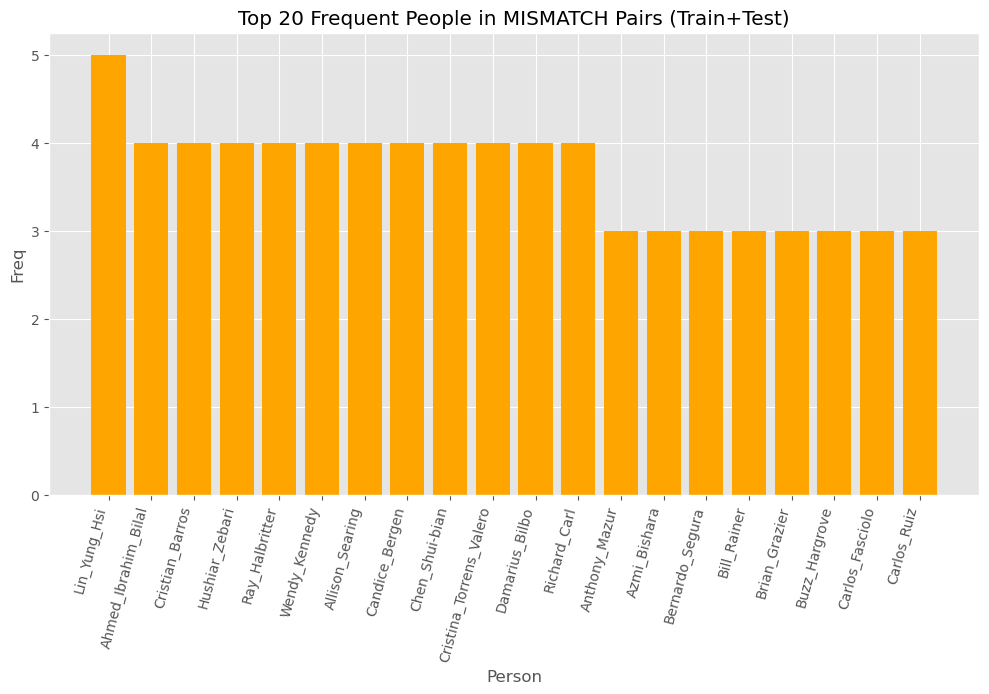

In [513]:
mismatchpairsDevTrain_df = pd.read_csv(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\mismatchpairsDevTrain.csv")
mismatchpairsDevTest_df = pd.read_csv(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\mismatchpairsDevTest.csv")

counts_train = Counter(mismatchpairsDevTrain_df["name"]) + Counter(mismatchpairsDevTrain_df["name.1"])
counts_test  = Counter(mismatchpairsDevTest_df["name"])  + Counter(mismatchpairsDevTest_df["name.1"])
total_counts = counts_train + counts_test

top20 = dict(sorted(total_counts.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(12,6))
plt.bar(top20.keys(), top20.values(), color="orange"); plt.xticks(rotation=75, ha="right")
plt.title("Top 20 Frequent People in MISMATCH Pairs (Train+Test)"); plt.xlabel("Person"); plt.ylabel("Freq")
plt.show()


<h4 style="color:#96c9ffff">
14. Checking for undirected duplicate face pairs in the mismatch test dataset by normalizing pair order and counting duplicates.
</h4>

In [514]:
pairs_test = mismatchpairsDevTest_df.apply(lambda r: tuple(sorted([(r["name"], int(r["imagenum1"])), (r["name.1"], int(r["imagenum2"]))])),axis=1)
print("Undirected duplicate pairs in test:", pd.Series(pairs_test).duplicated().sum())

Undirected duplicate pairs in test: 0


<h4 style="color:#96c9ffff">
15. Randomly sampling a matching pair from the dataset, loading both aligned images of the same person, and visualizing them side by side for comparison.
</h4>

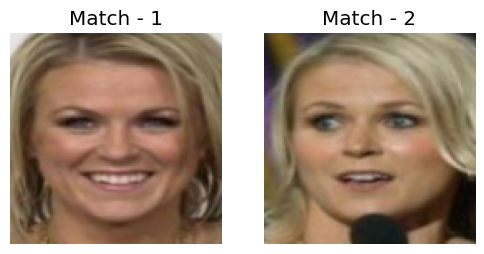

In [515]:
base_aligned = ALIGNED_ROOT

row = matchpairsDevTest_df.sample(1).iloc[0]
person = row["name"]
img1 = base_aligned / person / f"{person}_{int(row['imagenum1']):04d}.jpg"
img2 = base_aligned / person / f"{person}_{int(row['imagenum2']):04d}.jpg"
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(plt.imread(img1)); ax[0].axis("off"); ax[0].set_title("Match - 1")
ax[1].imshow(plt.imread(img2)); ax[1].axis("off"); ax[1].set_title("Match - 2")
plt.show()


<h4 style="color:#96c9ffff">
16. Randomly sampling a mismatching pair from the dataset, loading two aligned images of different people, and displaying them side by side for visual comparison.
</h4>

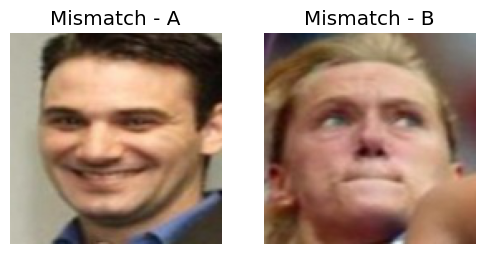

In [516]:
row = mismatchpairsDevTest_df.sample(1).iloc[0]
p1 = row["name"];    i1 = base_aligned / p1 / f"{p1}_{int(row['imagenum1']):04d}.jpg"
p2 = row["name.1"];  i2 = base_aligned / p2 / f"{p2}_{int(row['imagenum2']):04d}.jpg"
fig, ax = plt.subplots(1,2, figsize=(6,3))
ax[0].imshow(plt.imread(i1)); ax[0].axis("off"); ax[0].set_title("Mismatch - A")
ax[1].imshow(plt.imread(i2)); ax[1].axis("off"); ax[1].set_title("Mismatch - B")
plt.show()

<h4 style="color:#96c9ffff">
17. Defining the <code>plot_images</code> utility function to visualize a batch of images (up to 10) side by side using Matplotlib for quick inspection.
</h4>


In [517]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, min(10, len(images_arr)), figsize=(20, 2.2))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img.astype(np.uint8)); ax.axis('off')
    plt.tight_layout(); plt.show()


<h4 style="color:#96c9ffff">
18. Selecting a random aligned face image and applying data augmentation (rotation, shift, shear, zoom, and flip) using Keras <code>ImageDataGenerator</code>, then visualizing 10 augmented samples with the <code>plot_images</code> function.
</h4>

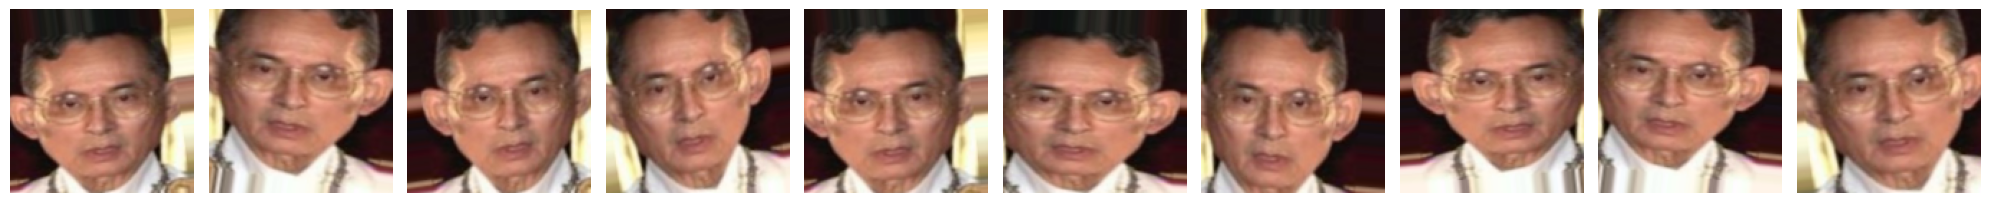

In [518]:
person_dir = random.choice([p for p in ALIGNED_ROOT.iterdir() if p.is_dir()])
image_path = random.choice(list(person_dir.glob("*.jpg")))
image = np.expand_dims(plt.imread(image_path), 0) 

gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,shear_range=0.1, zoom_range=0.1, horizontal_flip=True)
aug_iter = gen.flow(image, batch_size=1)
aug_images = [next(aug_iter)[0] for _ in range(10)]
plot_images(aug_images)

<h4 style="color:#96c9ffff">
19. Creating an output directory and generating 20 augmented face images with Keras <code>ImageDataGenerator</code>, saving them as JPEG files with a custom prefix for later use.
</h4>


In [519]:
save_dir = Path(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented")
save_dir.mkdir(parents=True, exist_ok=True)

img_in = image.copy()
if img_in.dtype in (np.float32, np.float64) and img_in.max() <= 1.0:
    img_in = (img_in * 255).astype("uint8")

gen_save = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

aug_iter = gen_save.flow(img_in, batch_size=1, save_to_dir=str(save_dir), save_prefix='aug-image-', save_format='jpeg')

num_to_save = 20

for _ in range(num_to_save):
    next(aug_iter)
    time.sleep(0.02)  
print("Saved", num_to_save, "augmented images to:", save_dir)


Saved 20 augmented images to: C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented


<h4 style="color:#96c9ffff">
20. Applying CLAHE (Contrast Limited Adaptive Histogram Equalization) on the luminance channel of the face image in YCrCb color space to enhance contrast and improve image quality.
</h4>


In [520]:
apply_clahe = True
img = plt.imread(image_path)  
if img.dtype != np.uint8:
    img8 = (img * 255).astype("uint8") if img.max() <= 1.0 else img.astype("uint8")
else:
    img8 = img

if apply_clahe:
    ycc = cv2.cvtColor(img8, cv2.COLOR_RGB2YCrCb)
    y, cr, cb = cv2.split(ycc)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    y_eq = clahe.apply(y)
    eq_rgb = cv2.cvtColor(cv2.merge([y_eq, cr, cb]), cv2.COLOR_YCrCb2RGB)
else:
    eq_rgb = img8


<h4 style="color:#96c9ffff">
21. Visualizing the effect of CLAHE by displaying the original aligned image alongside its enhanced version for comparison.
</h4>

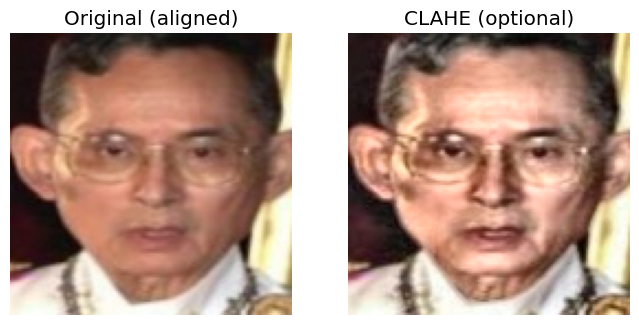

In [521]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(img8);   plt.axis("off"); plt.title("Original (aligned)")
plt.subplot(1,2,2); plt.imshow(eq_rgb); plt.axis("off"); plt.title("CLAHE (optional)")
plt.show()

<h4 style="color:#96c9ffff">
22. Reloading the matching pairs dataset from CSV, printing the total number of pairs, counting unique individuals, and displaying the first few rows for inspection.
</h4>


In [522]:
matchpairsDevTest_df = pd.read_csv(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\matchpairsDevTest.csv")
print("Total pairs:", len(matchpairsDevTest_df))
print("Unique people:", matchpairsDevTest_df["name"].nunique())
print(matchpairsDevTest_df.head())


Total pairs: 500
Unique people: 353
               name  imagenum1  imagenum2
0      Abdullah_Gul         13         14
1      Abdullah_Gul         13         16
2  Abdullatif_Sener          1          2
3    Adel_Al-Jubeir          1          3
4         Al_Pacino          1          2


<h4 style="color:#96c9ffff">
23. Counting the total number of unique images referenced in the matching pairs dataset by combining both image number columns.
</h4>

In [ ]:
all_imgs = pd.concat([matchpairsDevTest_df["imagenum1"], matchpairsDevTest_df["imagenum2"]])
print("Unique images referenced:", all_imgs.nunique())

Unique images referenced: 35


<h4 style="color:#96c9ffff">
24. Counting image usage frequency in the matching pairs dataset and displaying the top 10 most frequently referenced image indices.
</h4>

In [ ]:
from collections import Counter
counts = Counter(all_imgs)
print("Most used image indices:", counts.most_common(10))

Most used image indices: [(1, 292), (2, 288), (3, 141), (4, 84), (5, 39), (6, 30), (8, 17), (7, 16), (10, 13), (9, 11)]


<h4 style="color:#96c9ffff">
25. Sampling a random row from the matching pairs dataset and constructing file paths for the two corresponding aligned images of the same person.
</h4>

In [ ]:
base = Path(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\lfw-aligned-128")

row = matchpairsDevTest_df.sample(1).iloc[0]
person = row["name"]
img1 = base / person / f"{person}_{int(row['imagenum1']):04d}.jpg"
img2 = base / person / f"{person}_{int(row['imagenum2']):04d}.jpg"

<h4 style="color:#96c9ffff">
26. Displaying a sampled matching pair by loading and visualizing the two aligned images of the same person side by side with titles showing their indices.
</h4>

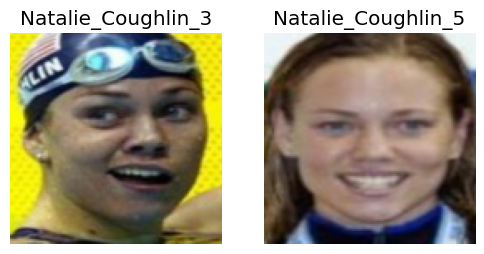

In [526]:

fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(Image.open(img1))
axes[0].set_title(f"{person}_{row['imagenum1']}")
axes[0].axis("off")

axes[1].imshow(Image.open(img2))
axes[1].set_title(f"{person}_{row['imagenum2']}")
axes[1].axis("off")
plt.show()


<h4 style="color:#96c9ffff">
27. Loading the match pairs training dataset, counting face occurrences, extracting the top 10 most frequent individuals, and visualizing their frequencies with a bar chart.
</h4>

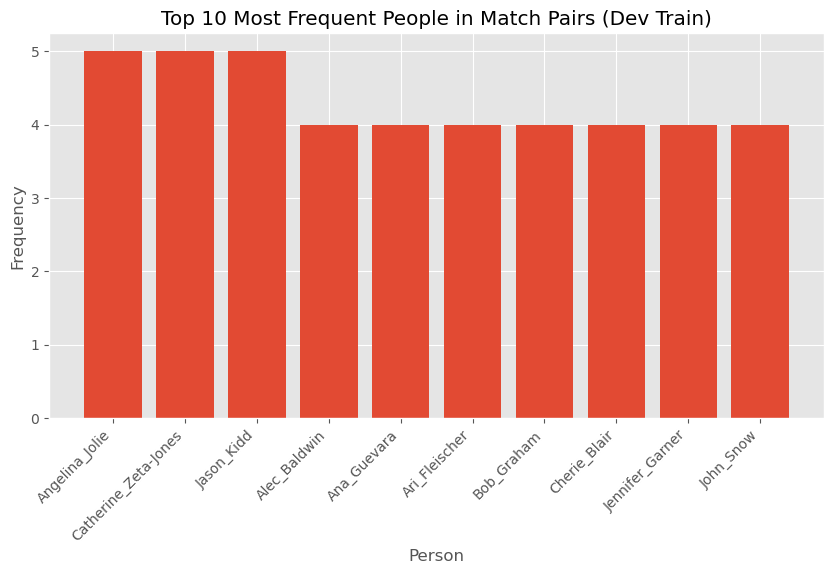

In [527]:
matchpairsDevTrain_df=pd.read_csv(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\matchpairsDevTrain.csv")
counts = Counter(matchpairsDevTrain_df["name"])

top10 = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:10])

plt.figure(figsize=(10,5))
plt.bar(top10.keys(), top10.values())
plt.title("Top 10 Most Frequent People in Match Pairs (Dev Train)")
plt.xlabel("Person")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()


<h4 style="color:#96c9ffff">
28. Checking for duplicate entries in the match pairs datasets by counting duplicates in both the test and train data.
</h4>

In [528]:
Test_duplicates = matchpairsDevTest_df.duplicated().sum()
print("Duplicate mismatched pairs in test data:", Test_duplicates)
Train_duplicates = matchpairsDevTrain_df.duplicated().sum()
print("Duplicate mismatched pairs in train data:", Train_duplicates)


Duplicate mismatched pairs in test data: 0
Duplicate mismatched pairs in train data: 0


<h4 style="color:#96c9ffff">
29. Sampling a random row from the mismatch pairs test dataset for further inspection or visualization.
</h4>

In [529]:
row = mismatchpairsDevTest_df.sample(1).iloc[0]
plt.show()

<h4 style="color:#96c9ffff">
30. Visualizing a sampled mismatching pair by loading and displaying two aligned images from different people side by side with their indices as titles.
</h4>

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

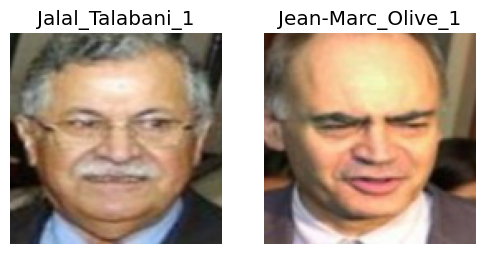

In [530]:
person1 = row["name"]
img1 = base / person1 / f"{person1}_{int(row['imagenum1']):04d}.jpg"

person2 = row["name.1"]
img2 = base / person2 / f"{person2}_{int(row['imagenum2']):04d}.jpg"

fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(Image.open(img1))
axes[0].set_title(f"{person1}_{row['imagenum1']}")
axes[0].axis("off")

axes[1].imshow(Image.open(img2))
axes[1].set_title(f"{person2}_{row['imagenum2']}")
axes[1].axis("off")


<h4 style="color:#96c9ffff">
31. Sampling a random mismatching pair from the training dataset and constructing file paths for the two aligned images belonging to different individuals.
</h4>

In [531]:
mismatchpairsDevTrain_df = pd.read_csv(r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\mismatchpairsDevTrain.csv")

row = mismatchpairsDevTrain_df.sample(1).iloc[0]

person1 = row["name"]
img1 = base / person1 / f"{person1}_{int(row['imagenum1']):04d}.jpg"


person2 = row["name.1"]
img2 = base / person2 / f"{person2}_{int(row['imagenum2']):04d}.jpg"


<h4 style="color:#96c9ffff">
32. Displaying a sampled mismatching training pair by visualizing two aligned images of different people side by side with their indices as titles.
</h4>

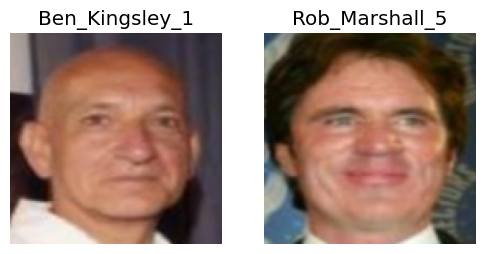

In [532]:
fig, axes = plt.subplots(1, 2, figsize=(6,3))
axes[0].imshow(Image.open(img1))
axes[0].set_title(f"{person1}_{row['imagenum1']}")
axes[0].axis("off")

axes[1].imshow(Image.open(img2))
axes[1].set_title(f"{person2}_{row['imagenum2']}")
axes[1].axis("off")

plt.show()

<h4 style="color:#96c9ffff">
33. Counting face occurrences in the mismatching training dataset, extracting the top 20 most frequent individuals, and visualizing their frequencies with a bar chart.
</h4>

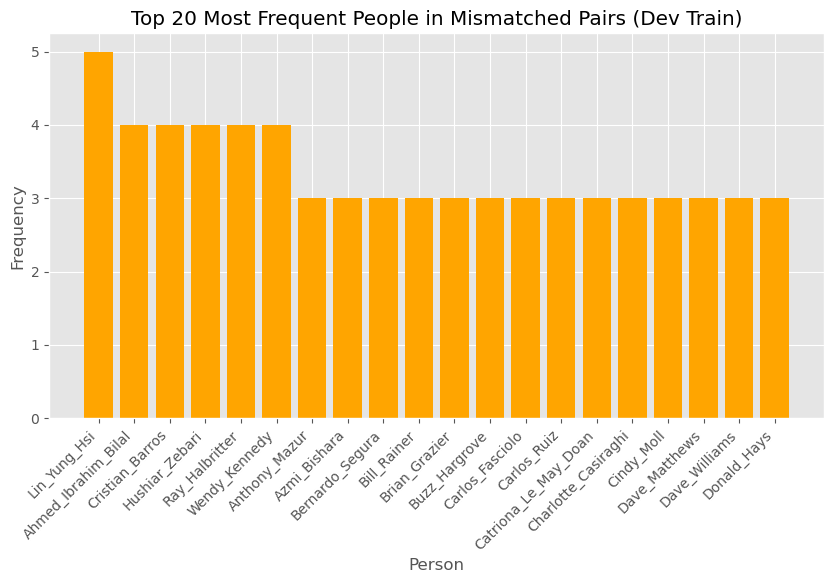

In [ ]:
counts = Counter(mismatchpairsDevTrain_df["name"]) + Counter(mismatchpairsDevTrain_df["name.1"])

top20 = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(10,5))
plt.bar(top20.keys(), top20.values(), color="orange")
plt.title("Top 20 Most Frequent People in Mismatched Pairs (Dev Train)")
plt.xlabel("Person")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()


<h4 style="color:#96c9ffff">
34. Counting face occurrences in the mismatching test dataset, selecting the top 20 most frequent individuals, and visualizing their frequencies with a bar chart.
</h4>

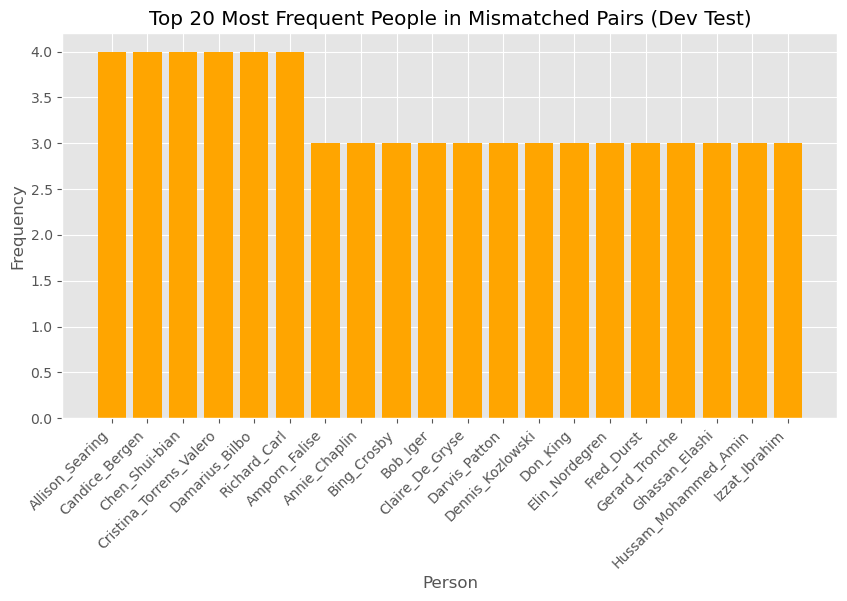

In [534]:
counts = Counter(mismatchpairsDevTest_df["name"]) + Counter(mismatchpairsDevTest_df["name.1"])

top20 = dict(sorted(counts.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(10,5))
plt.bar(top20.keys(), top20.values(), color="orange")
plt.title("Top 20 Most Frequent People in Mismatched Pairs (Dev Test)")
plt.xlabel("Person")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")
plt.show()


<h4 style="color:#96c9ffff">
35. Aggregating face occurrence counts from both mismatching train and test datasets, extracting the top 20 most frequent individuals, and visualizing them with a combined bar chart.
</h4>

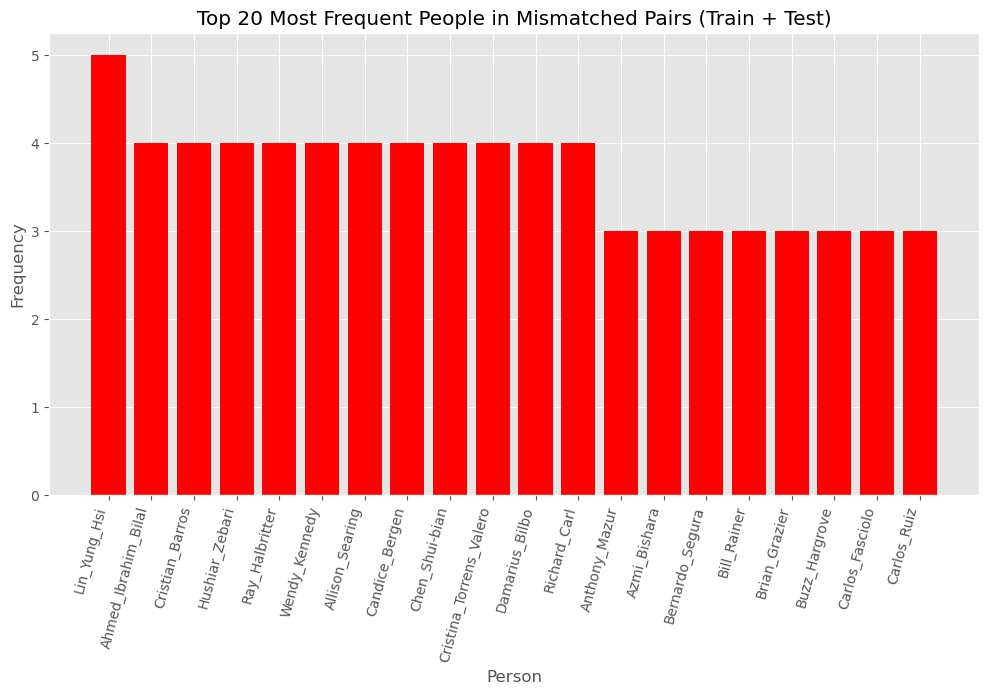

In [535]:
counts_train = Counter(mismatchpairsDevTrain_df["name"]) + Counter(mismatchpairsDevTrain_df["name.1"])
counts_test = Counter(mismatchpairsDevTest_df["name"]) + Counter(mismatchpairsDevTest_df["name.1"])
total_counts = counts_train + counts_test

top20 = dict(sorted(total_counts.items(), key=lambda x: x[1], reverse=True)[:20])

plt.figure(figsize=(12,6))
plt.bar(top20.keys(), top20.values(), color="red")
plt.title("Top 20 Most Frequent People in Mismatched Pairs (Train + Test)")
plt.xlabel("Person")
plt.ylabel("Frequency")
plt.xticks(rotation=75, ha="right")
plt.show()


<h4 style="color:#96c9ffff">
36. Defining the <code>plotImages</code> utility function to visualize a batch of up to 10 images side by side for quick inspection.
</h4>

In [536]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

<h4 style="color:#96c9ffff">
37. Initializing a Keras <code>ImageDataGenerator</code> with extensive augmentation settings (rotation, shift, shear, zoom, channel shift, and horizontal flip) for training data variability.
</h4>

In [ ]:
gen = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True)

<h4 style="color:#96c9ffff">
38. Randomly selecting a person and one of their images from the aligned dataset, then printing the chosen person’s name and image path.
</h4>

In [ ]:
chosen_person = random.choice(os.listdir(base))
person_path = os.path.join(base, chosen_person)

chosen_image = random.choice(os.listdir(person_path))
image_path = os.path.join(person_path, chosen_image)

print("Person:", chosen_person)
print("Image path:", image_path)


Person: Kent_McCord
Image path: C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\Data\lfw-aligned-128\Kent_McCord\Kent_McCord_0001.jpg


<h4 style="color:#96c9ffff">
39. Loading the selected image, expanding its dimensions to match model input format, and displaying it for verification.
</h4>

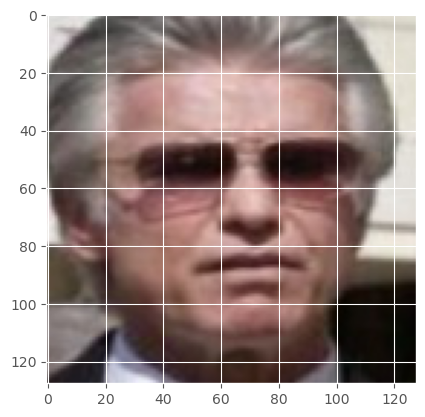

In [539]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

<h4 style="color:#96c9ffff">
40. Generating a batch of 10 augmented versions of the selected image using <code>ImageDataGenerator</code> and visualizing them with the <code>plotImages</code> function.
</h4>

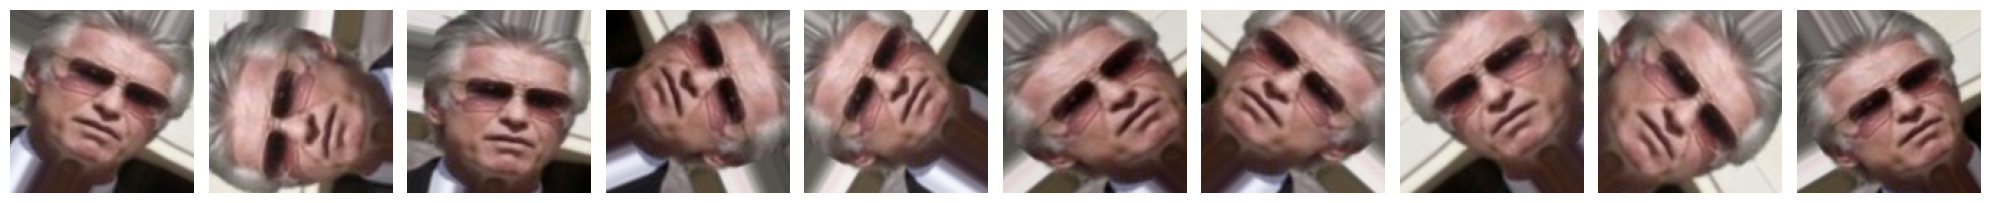

In [ ]:
aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plotImages(aug_images)

<h4 style="color:#96c9ffff">
41. Preparing to generate and save 36 augmented images by creating the output directory, normalizing input image format, configuring <code>ImageDataGenerator</code>, and initializing the augmentation iterator with saving options.
</h4>

In [ ]:
num_to_save = 36  
save_dir = r"C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented"

os.makedirs(save_dir, exist_ok=True)

img_in = image.copy() 
if img_in.dtype in (np.float32, np.float64) and img_in.max() <= 1.0:
    img_in = (img_in * 255).astype("uint8") 

gen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1,shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

aug_iter = gen.flow(img_in,save_to_dir=save_dir,save_prefix='aug-image-',save_format='jpeg',batch_size=1)
seen = set(os.listdir(save_dir))

<h4 style="color:#96c9ffff">
42. Generating and saving the augmented images to disk, then collecting the newly created files for further use.
</h4>

In [542]:
for _ in range(num_to_save):
    next(aug_iter)
    time.sleep(0.02)  

now = set(os.listdir(save_dir))
new_files = sorted([f for f in (now - seen) if f.startswith('aug-image-') and f.endswith('.jpeg')])

new_files = new_files[:num_to_save]

<h4 style="color:#96c9ffff">
43. Printing the list of saved augmented image files with their full paths for verification.
</h4>

In [543]:
print("Saved files:")
for i, f in enumerate(new_files, 1):
    print(f"{i:02d}. {os.path.join(save_dir, f)}")

Saved files:
01. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_1209.jpeg
02. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_1506.jpeg
03. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_1646.jpeg
04. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_177.jpeg
05. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_1898.jpeg
06. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_2124.jpeg
07. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_2981.jpeg
08. C:\Users\Rammah\OneDrive\Desktop\اجازه ان شاء الله\Projects\Facial Recognition System\augmented\aug-image-_0_3171.jpeg
09. 

<h4 style="color:#96c9ffff">
44. Displaying the saved augmented images in a grid layout using Matplotlib, adjusting rows and columns dynamically based on the number of images.
</h4>

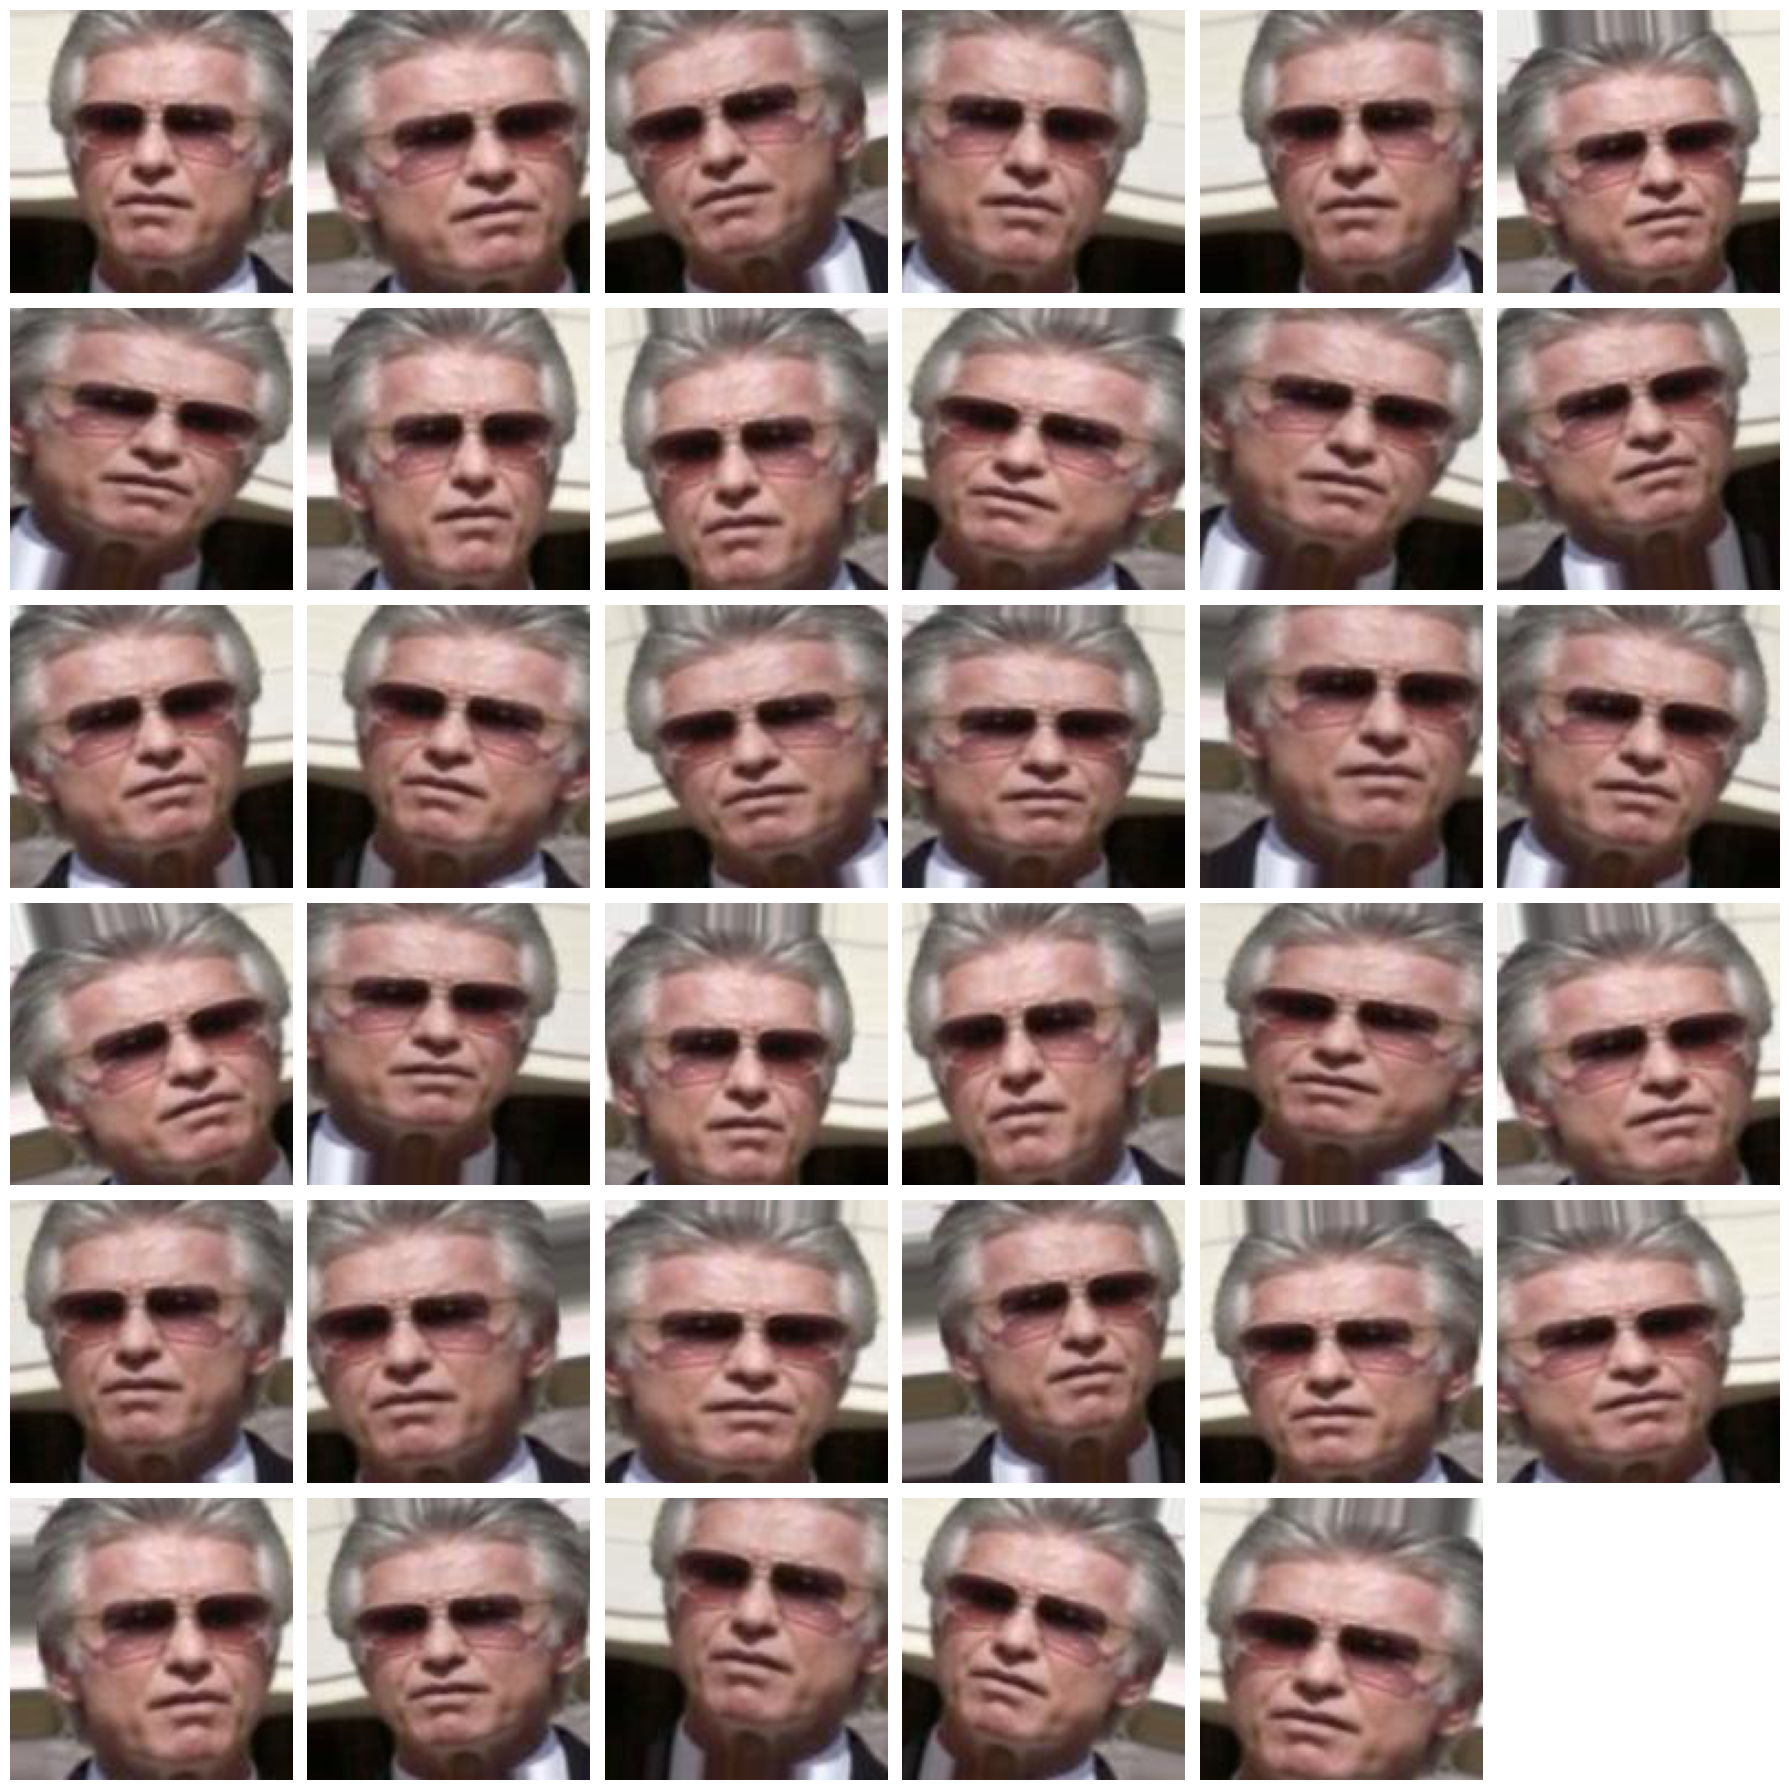

In [544]:
paths = [os.path.join(save_dir, f) for f in new_files]
cols = min(6, len(paths))
rows = math.ceil(len(paths) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
if rows == 1:
    axes = np.array(axes).reshape(1, -1)
axes = axes.flatten()
for ax, p in zip(axes, paths):
    img = plt.imread(p)
    ax.imshow(img)
    ax.axis("off")

for i in range(len(paths), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()